In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rn

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import seaborn as sns
%pylab inline
plt.style.use("bmh")

import sklearn
print(sklearn.__version__)
# assert ('0.22' == sklearn.__version__[:4])
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, train_test_split
from sklearn.utils.testing import all_estimators
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import VotingClassifier

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier

RS = 77
rn.seed(RS)
np.random.seed(RS)
np.random.RandomState(RS)

import warnings
warnings.filterwarnings('ignore')
import os
from pathlib import Path

data_folder = Path('/kaggle/input')
for dirname, _, filenames in os.walk(data_folder):
    for filename in filenames:
#         print(os.path.join(dirname, filename))
        print(data_folder / filename)
print('end')
# Any results you write to the current directory are saved as output.

Populating the interactive namespace from numpy and matplotlib
0.21.3
/kaggle/input/train.csv
/kaggle/input/gender_submission.csv
/kaggle/input/test.csv
end


In [2]:
df_train = pd.read_csv('../input/titanic/train.csv', index_col='PassengerId')
df_test = pd.read_csv('../input/titanic/test.csv', index_col='PassengerId')

df_titanic = pd.concat([df_train, df_test], sort=False)
len_train = df_train.shape[0]

# df_titanic
df_titanic.isna().sum()
# df_train.describe()
# df_train.info()

Survived     418
Pclass         0
Name           0
Sex            0
Age          263
SibSp          0
Parch          0
Ticket         0
Fare           1
Cabin       1014
Embarked       2
dtype: int64

In [3]:
df_titanic

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S


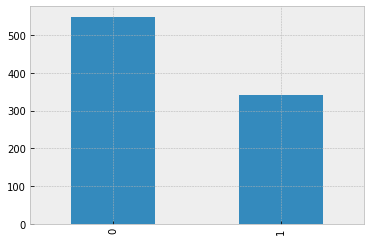

In [4]:
df_train['Survived'].value_counts().plot.bar();

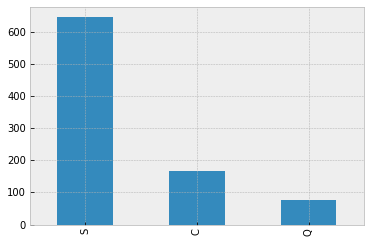

In [5]:
df_train['Embarked'].value_counts().plot.bar();

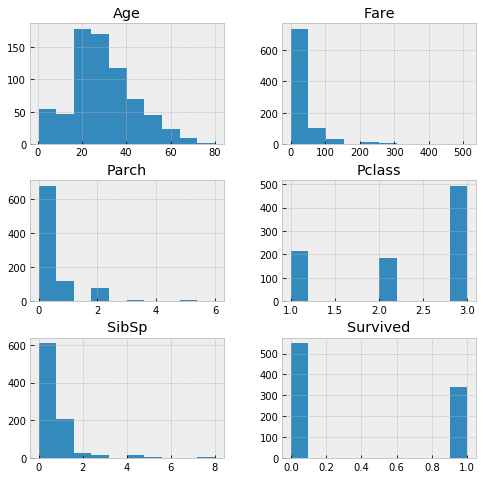

In [6]:
fig, ax = plt.subplots(figsize=(8,8))
fig.patch.set_facecolor('w')
df_train.hist(ax=ax);

In [7]:
df_train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Navratil, Mr. Michel (""Louis M Hoffman"")",male,347082,C23 C25 C27,S
freq,1,577,7,4,644


   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


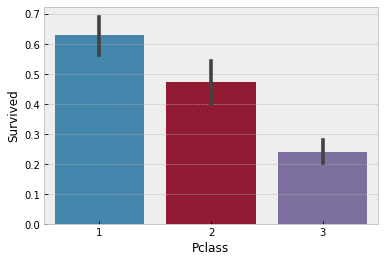

In [8]:
print(df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False))
sns.barplot('Pclass','Survived',data=df_train);

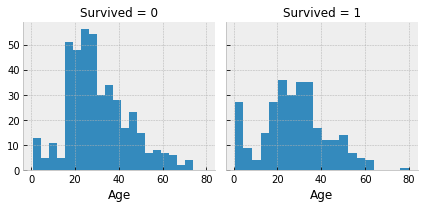

In [9]:
g = sns.FacetGrid(df_train, col='Survived')
g.map(plt.hist, 'Age', bins=20);

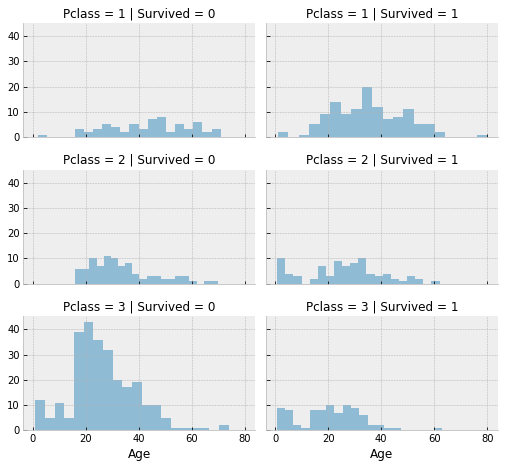

In [10]:
grid = sns.FacetGrid(df_train, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Relatives,Ticket2,Ticket3,Ticket4,Ticket5,AgexClass,Cabin2,Name2,IsAlone,Survived
PassengerId,,,,,,,,,,,,,,,,,,
1,3,1,2,1,0,0,0.339009,0.156673,1,9,21171,0.100000,4,6,0,6,0,0
2,1,0,5,1,0,2,0.553571,0.792000,1,8,17599,0.650000,3,5,3,7,0,1
3,3,0,3,0,0,0,0.339009,0.697802,0,16,3101282,0.500000,9,9,0,9,1,1
4,1,0,5,1,0,2,0.339009,0.792000,1,6,113803,0.384266,0,5,4,8,0,1
5,3,1,5,0,0,0,0.339009,0.156673,0,6,373450,0.384266,0,15,0,5,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,2,1,3,0,0,1,0.339009,0.000000,0,6,211536,0.384266,0,6,0,8,1,0
888,1,0,1,0,0,2,0.339009,0.697802,0,6,112053,0.384266,0,1,3,6,1,1
889,3,0,0,1,2,1,0.339009,0.697802,3,10,6607,0.111111,6,0,0,8,0,0


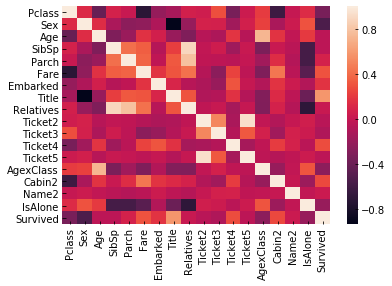

In [11]:
from sklearn.cross_decomposition import PLSCanonical

def label_encoding(df, column):
    return LabelEncoder().fit_transform(df[column])

def target_encoding(df, column, method=mean):
    return df[column].map(df.groupby(column)['Survived'].agg(method).fillna(0))
#     cumsum = df.groupby(column)['Survived'].cumsum() - df['Survived']
#     cumcnt = df.groupby(column).cumcount()
#     df[column] = cumsum/cumcnt
#     return df[column].fillna(df['Survived'].mean(), inplace=True)

def onehot_encoding(df, column):
    return pd.concat([df,pd.get_dummies(df[column], prefix=column.lower()[:3])],axis=1).drop([column], axis=1)

def to_bins(df, column, bins):
    return pd.qcut(df[column], bins, labels=range(bins)).astype(int)
    
def data_prep(train=True, drop=True):
    def restore_age_inner(X, rgrs = PLSCanonical):        
        idx_na = X.Age.isna()

        X_train,X_test  = X.loc[~idx_na], X.loc[idx_na]
        y_train = X_train.pop('Age')
        X_test.pop('Age')
        
        assert(X_train.isna().sum().sum()>0)
            
        pred = rgrs().fit(X_train, y_train).predict(X_test)

        X.Age[idx_na] = pred
        return X.Age
    
    df = df_titanic.copy()
    
    df.Sex = df.Sex.map({'male': 1, 'female': 0})
    df.Embarked = df.Embarked.fillna(df.Embarked.mode()[0])
    df.Embarked = target_encoding(df, 'Embarked')
    df['Title'] = df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    df.Title = target_encoding(df, 'Title')

#     df = onehot_encoding(df, 'Pclass')

    df.Fare = df.Fare.fillna(df.Fare.median())
    df.Fare = to_bins(df, 'Fare', 3)
    
#     for i in range(2,8):
#         df['Fare_'+str(i)] = to_bins(df, 'Fare', i)
#     df = df.drop(['Fare'], axis=1)

    df['Relatives'] = df.SibSp + df.Parch
    df['Ticket2'] = df.Ticket.str.len()
    df['Ticket3'] = df.Ticket.str.extract(r'(\d+$)', expand=False).fillna(0).astype(int)
    df['Ticket4'] = df.Ticket.str.replace(r'(\d+$)', '')
    df['Ticket5'] = df.Ticket4.str.len()
    df['Ticket4'] = target_encoding(df, 'Ticket4')
    
    df.Age = restore_age_inner(df.drop(['Name', 'Ticket', 'Cabin', 'Survived'], axis=1))
    
#     for i in range(4,10):
#         df['Age_'+str(i)] = to_bins(df, 'Age', i)
#         df['AgexClass_'+str(i)] = df['Pclass'] * df['Age_'+str(i)]

    df.Age = to_bins(df, 'Age', 8)
    df['AgexClass'] = df['Pclass'] * df['Age']

#     estimators = all_estimators(type_filter='regressor')
#     for name, class_ in estimators:
#         try:
#             tmp = restore_age_inner(df.drop(['Name', 'Ticket', 'Cabin', 'Survived'], axis=1), rgrs=class_)
#             if tmp.isna().sum() == 0: df['Age_'+name] =  tmp
#         except:
#           print('failed ', name, ',', end='')
#           pass
    
    df['Cabin2']=df['Cabin'].fillna('').str.len()
    df['Name2']=df.Name.apply(lambda x: len(x.split(',')[0].strip()))
    df['IsAlone'] = (df['Relatives'] == 0).astype(int)

    if drop:
        df = df.drop(['Name', 'Ticket', 'Cabin'], axis=1)

    TARGET = 'Survived'
    FTS = [col for col in df.columns if col != TARGET]
    if train:
        df = df[:len_train]
        return df[FTS], df[TARGET].astype(int)
    else:
        df = df[len_train:]
        return df[FTS], []

X, y = data_prep()
X['Survived'] = y

import seaborn as sns
sns.heatmap(X.corr())

X

0.9049418099908492
('Age', 'Fare', 'Title', 'Relatives', 'Ticket3', 'Ticket4', 'Ticket5', 'AgexClass', 'IsAlone')


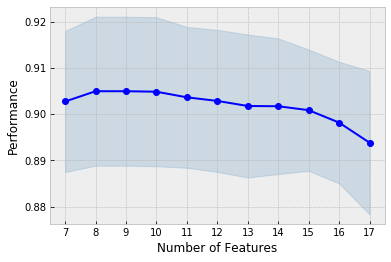

In [28]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

n_folds = 5
X, y = data_prep()

model = XGBClassifier(random_state=RS)
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=RS)

sfs1 = SFS(model, 
           k_features=(7, X.shape[1]),
           forward=False, 
           floating=False, 
           verbose=0,
           scoring='roc_auc',
           n_jobs=-1,
           cv=skf)

sfs1 = sfs1.fit(X, y)

print(sfs1.k_score_)
print(sfs1.k_feature_names_)
fig1 = plot_sfs(sfs1.get_metric_dict(), kind='std_dev')
plt.show()

In [ ]:
0.9049418099908492
('Age', 'Fare', 'Title', 'Relatives', 'Ticket3', 'Ticket4', 'Ticket5', 'AgexClass', 'IsAlone')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


0.879 ± 0.007
0.905 ± 0.016


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


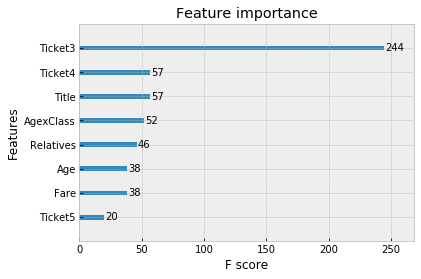

In [29]:
X, y = data_prep()
n_folds = 5
    
FTS = list( \
('Age', 'Fare', 'Title', 'Relatives', 'Ticket3', 'Ticket4', 'Ticket5', 'AgexClass')
          )
X = X[FTS]
    
# bias, variance = X['Fare'].mean(), X['Fare'].std()
# X['Fare'] = (X['Fare']-bias)/variance
    
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=RS)
model = XGBClassifier(random_state=RS)
scores = cross_val_score(model, X, y, scoring='roc_auc', verbose=1, n_jobs=-1, cv=skf)

X_train, X_cv, y_train, y_cv = train_test_split(X, y, random_state=RS, shuffle=True, test_size=0.2)
model.fit(X_train, y_train,
        eval_set=[(X_cv, y_cv)],
        early_stopping_rounds=200,
        verbose=0,
        eval_metric = 'auc',
        )
print(f'{np.mean(model.evals_result()["validation_0"]["auc"]):.3f} ± {np.std(model.evals_result()["validation_0"]["auc"]):.3f}')
print(f'{np.mean(scores):.3f} ± {np.std(scores):.3f}')
xgb.plot_importance(model)

In [ ]:
X, y = data_prep(drop=False)
X['Survived'] = y

warnings.filterwarnings(action="ignore")
plt.figure(figsize=[12,10])
plt.subplot(3,3,1)
sns.barplot('Pclass','Survived',data=X)
plt.subplot(3,3,2)
sns.barplot('SibSp','Survived',data=X)
plt.subplot(3,3,3)
sns.barplot('Parch','Survived',data=X)
plt.subplot(3,3,4)
sns.barplot('Sex','Survived',data=X)
plt.subplot(3,3,5)
sns.barplot('Ticket','Survived',data=X)
plt.subplot(3,3,6)
sns.barplot('Cabin','Survived',data=X)
plt.subplot(3,3,7)
sns.barplot('Embarked','Survived',data=X)
plt.subplot(3,3,8)
sns.distplot(X[X.Survived==1].Age, color='green', kde=False)
sns.distplot(X[X.Survived==0].Age, color='orange', kde=False)
plt.subplot(3,3,9)
sns.distplot(X[X.Survived==1].Fare, color='green', kde=False)
sns.distplot(X[X.Survived==0].Fare, color='orange', kde=False)

In [ ]:
X, y = data_prep(drop=False)
X['Survived'] = y
plt.figure(figsize=[12,10])
plt.subplot(3,3,1)
sns.barplot('Relatives','Survived',data=X)
plt.subplot(3,3,2)
sns.barplot('Ticket2','Survived',data=X)
plt.subplot(3,3,3)
sns.barplot('Adult_male','Survived',data=X)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

def estimate(X, y):
  estimators = all_estimators(type_filter='classifier')

  res = []
  for name, class_ in estimators:
#     scores = cross_val_score(class_(), X, y, cv=5, scoring='roc_auc')
    try:
      scores = cross_val_score(class_(), X, y, cv=5, scoring='roc_auc')
      if scores.mean() > 0.8:
        print(f'{name} ROC_AUC CV: {scores.mean():.3f} ± {scores.std():.3f}')
        res.append((scores.mean(), name))
    except:
      pass

#     model = VotingClassifier(estimators=[('clf1', clf1), ('clf2', clf2), ('clf3', clf3)], voting='soft')

  print('\nBest model: ', max(res))
    
X, y = data_prep()

res = estimate(X, y)
model = GradientBoostingClassifier().fit(X, y)

In [62]:
def get_best_params_xgbc():
  estimators = 17
  return {
#   'base_score': 0.9883241431311958, 
#   'booster': 'gbtree',
#   'colsample_bylevel': 0.8954745282201794, 
#   'colsample_bynode': 0.9053728787963939, 
#   'colsample_bytree': 0.37737648074076036, 
#   'gamma': 51, 
  'learning_rate': 0.13, 
#   'max_delta_step': 22, 
  'max_depth': 8, 
#   'min_child_weight': 0.8940873051252118, 
#   'missing': None,
  'n_estimators': estimators, 
#   'nthread': None,
#   'objective': 'binary:logistic',
#   'reg_alpha': 0.2901487558842103, 
#   'reg_lambda': 0.7240220329478356, 
#   'scale_pos_weight': 0.11997115325466545,  #0.04082
#   'seed': None,
#   'silent': None,
#   'subsample': 0.699092108437742,
  # If there’s more than one metric in the eval_metric parameter given in params, the last metric will be used for early stopping
#   'eval_metric': ['logloss', 'auc'],
#   'criterion': 'gini',
  # 'rmse', 'rmsle', 'mae', 'logloss', 'error', 'error@t', 'merror', 'mlogloss', 'auc', 'aucpr', 'ndcg', 'map', 'ndcg@n', 'ndcg@n', 'ndcg-', 'map-', 'ndcg@n-', 'ndcg@n-'
#   'tree_method': 'gpu_hist',
#   'updater': 'grow_gpu_hist',
#   'predictor': 'gpu_predictor',
  'random_state': RS,
  'verbosity': 0,
  }

def get_best_params_lgbm():
  estimators = 203
  return {
#     'boosting_type': 'gbdt',
#     'class_weight': None,
#     'colsample_bytree': 0.3811304824216669,
#     'importance_type': 'split',
#     'learning_rate': 0.016659893432998896,
#     'max_depth': 20,
#     'metric': ['logloss', 'auc'],
#     'min_child_samples': 12,
#     'min_child_weight': 0.0036350360157623163,
#     'min_split_gain': 0.9619961904304549,
#     'n_estimators': estimators,
#     'n_jobs': -1,
#     'num_leaves': 32,
#     'objective': 'binary',
#     'reg_alpha': 0.8022751137716411,
#     'reg_lambda': 0.8186913351852023,
#     'silent': True,
#     'subsample': 0.5967826661188248,
#     'subsample_for_bin': 200000,
#     'subsample_freq': 14
      'random_state': RS,
    }

In [63]:
from sklearn.metrics import roc_auc_score, roc_curve

def cutoff(target, predicted):
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr))
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
    return list(roc_t['threshold'])

X, y = data_prep()
X_, _ = data_prep(train=False)

FTS = list( \
('Age', 'Fare', 'Title', 'Relatives', 'Ticket3', 'Ticket4', 'Ticket5', 'AgexClass')
          )
X = X[FTS]
X_ = X_[FTS]

n_folds = 5
df_pred = pd.DataFrame(np.zeros(X_.shape[0]), columns=['Survived'], index=X_.index)

skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=RS)
scores = []
cutoffs = []
for train_index,cv_index in skf.split(X,y):
    X_train,X_cv = X.values[train_index], X.values[cv_index]
    y_train,y_cv = y.values[train_index], y.values[cv_index]
    
#     model = XGBClassifier(**get_best_params_xgbc())
    model = XGBClassifier(random_state=RS)    
    model.fit(X_train, y_train,
        eval_set=[(X_cv, y_cv)],
        early_stopping_rounds=200,
        verbose=False,
        eval_metric = 'auc', 
        )

    predict = model.predict_proba(X_cv)[:, 1]
    scores.append( roc_auc_score(y_cv, predict) )
    cutoffs.append( cutoff(y_cv, predict) )
    
    if hasattr(model, 'best_ntree_limit'):
      predict = model.predict_proba(X_.values, ntree_limit=model.best_ntree_limit)
    else:
      predict = model.predict_proba(X_.values)
    
    df_pred.Survived += predict[:,1]/n_folds
    
print(f'auc: {np.mean(scores):.3f} ± {np.std(scores):.3f}')
print(f'cut: {np.mean(cutoffs):.3f} ± {np.std(cutoffs):.3f}')

auc: 0.907 ± 0.015
cut: 0.349 ± 0.041


In [ ]:
X, y = data_prep()

FTS = list( \
('Age', 'Fare', 'Title', 'Relatives', 'Ticket3', 'Ticket4', 'Ticket5', 'AgexClass')
          )
X = X[FTS]

n_folds = 5
        
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=RS)
model = LGBMClassifier(**get_best_params_lgbm())
scores = cross_val_score(model, X, y, scoring='roc_auc', verbose=1, n_jobs=-1, cv=skf)

model.fit(X, y,
#         eval_set=[data_prep(df_oof)],
#         early_stopping_rounds=200,
        verbose=False,
        eval_metric = 'auc', 
        )
print(f'{np.mean(scores):.3f} ± {np.std(scores):.3f}')

feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(30).plot(kind='barh')
print(feat_importances.nlargest(30).index)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
X, y = data_prep()

FTS = list( \
('Age', 'Fare', 'Title', 'Relatives', 'Ticket3', 'Ticket4', 'Ticket5', 'AgexClass')
          )
X = X[FTS]

clf = XGBClassifier(**get_best_params_xgbc())
PRF=[{'n_estimators':[13, 14, 16, 17, 18],
      'max_depth':[6, 7, 8, 9],
      'learning_rate': [0.12, 0.13, 0.15, 0.2],
#       'eval_metric': ['logloss', 'auc'],
#       'criterion':['gini','entropy', 'logloss', 'auc']
     }]
# GSRF=GridSearchCV(estimator=clf, param_grid=PRF, scoring='roc_auc',cv=5).fit(X, y)
GSRF=GridSearchCV(estimator=clf, param_grid=PRF, scoring='accuracy',cv=5).fit(X, y)
print(GSRF.best_params_)
# scores_rf=cross_val_score(GSRF,X,y,scoring='roc_auc',cv=5)
# print(f'{np.mean(scores_rf):.3f} ± {np.std(scores_rf):.3f}')

In [ ]:
X_, _ = data_prep(train=False)
# X = pca.transform(X_)

if hasattr(model, 'best_ntree_limit'):
  predict = model.predict(X_, ntree_limit=model.best_ntree_limit)
else:
  predict = model.predict(X_)

df_pred = pd.DataFrame(predict, columns=['Survived'], index=X_.index)
df_pred.to_csv('submission.csv')

print(df_pred)

In [65]:
cutoffs

[[0.3153556287288666],
 [0.3449295461177826],
 [0.34491124749183655],
 [0.3149895966053009],
 [0.42569485306739807]]

In [66]:
df_submit = df_pred.copy()
df_submit.Survived = df_pred.Survived.apply(lambda x: 1 if x > np.max(cutoffs) else 0)
df_submit.to_csv('submission2.csv')

print(df_submit)

             Survived
PassengerId          
892                 0
893                 1
894                 0
895                 0
896                 1
...               ...
1305                0
1306                0
1307                0
1308                0
1309                1

[418 rows x 1 columns]
